<a href="https://colab.research.google.com/github/mimithecoconut/155projects-/blob/main/covid_herd_immunity_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates
import numpy as np
import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import math
from sklearn.preprocessing import StandardScaler

# Preprocessing for Prelimary Data Examination

In [ ]:
# loads relevant data
vaccines = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/us_state_vaccinations.csv', index_col= 'location')
cases = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv', index_col= 'iso_code')
total_vaccines = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/vaccinations.csv', index_col = 'iso_code')

In [ ]:
# reformats dates
vaccines['date'] = (vaccines['date'].str[5:7] + vaccines['date'].str[-2::]).astype(int)
v_features = ['date','total_vaccinations','people_vaccinated','people_fully_vaccinated','daily_vaccinations']
vaccines

,date,total_vaccinations,total_distributed,people_vaccinated,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,people_fully_vaccinated,people_vaccinated_per_hundred,distributed_per_hundred,daily_vaccinations_raw,daily_vaccinations,daily_vaccinations_per_million,share_doses_used
location,,,,,,,,,,,,,
Alabama,112,78134.0,377025.0,70861.0,0.15,1.59,7270.0,1.45,7.69,NaN,NaN,NaN,0.207
Alabama,113,84040.0,378975.0,74792.0,0.19,1.71,9245.0,1.53,7.73,5906.0,5906.0,1205.0,0.222
Alabama,114,92300.0,435350.0,80480.0,NaN,1.88,NaN,1.64,8.88,8260.0,7083.0,1445.0,0.212
Alabama,115,100567.0,444650.0,86956.0,0.28,2.05,13488.0,1.77,9.07,8267.0,7478.0,1525.0,0.226
Alabama,116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7557.0,7498.0,1529.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wyoming,520,384358.0,499235.0,207907.0,30.81,66.41,178309.0,35.92,86.26,3153.0,1372.0,2371.0,0.770
Wyoming,521,385924.0,500415.0,208848.0,30.93,66.68,179026.0,36.09,86.46,1566.0,1355.0,2341.0,0.771
Wyoming,522,388011.0,501825.0,210083.0,31.12,67.04,180097.0,36.30,86.71,2087.0,1333.0,2303.0,0.773


In [ ]:

cases['date'] = matplotlib.dates.num2date(matplotlib.dates.datestr2num(cases['date']))
cases = cases.filter(like='USA', axis=0)
cases = cases.loc[:,['date', 'total_cases', 'new_cases'] ]

In [ ]:
cases = cases.dropna()
cases

,date,total_cases,new_cases
iso_code,,,
USA,2020-01-23 00:00:00+00:00,1.0,0.0
USA,2020-01-24 00:00:00+00:00,2.0,1.0
USA,2020-01-25 00:00:00+00:00,2.0,0.0
USA,2020-01-26 00:00:00+00:00,5.0,3.0
USA,2020-01-27 00:00:00+00:00,5.0,0.0
...,...,...,...
USA,2021-05-20 00:00:00+00:00,33056765.0,30141.0
USA,2021-05-21 00:00:00+00:00,33085106.0,28341.0
USA,2021-05-22 00:00:00+00:00,33104884.0,19778.0


In [ ]:
# convert date format into yyyy-mm-dd
total_vaccines['date'] = matplotlib.dates.num2date(matplotlib.dates.datestr2num(total_vaccines['date']))
# get USA data only
total_vaccines = total_vaccines.filter(like='USA', axis=0)

In [ ]:
# total_vaccines = total_vaccines.dropna()
total_vaccines

,location,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million
iso_code,,,,,,,,,,,
USA,United States,2020-12-20 00:00:00+00:00,556208.0,556208.0,NaN,NaN,NaN,0.17,0.17,NaN,NaN
USA,United States,2020-12-21 00:00:00+00:00,614117.0,614117.0,NaN,57909.0,57909.0,0.18,0.18,NaN,173.0
USA,United States,2020-12-22 00:00:00+00:00,NaN,NaN,NaN,NaN,127432.0,NaN,NaN,NaN,381.0
USA,United States,2020-12-23 00:00:00+00:00,1008025.0,1008025.0,NaN,NaN,150606.0,0.30,0.30,NaN,450.0
USA,United States,2020-12-24 00:00:00+00:00,NaN,NaN,NaN,NaN,191001.0,NaN,NaN,NaN,571.0
...,...,...,...,...,...,...,...,...,...,...,...
USA,United States,2021-05-19 00:00:00+00:00,277290173.0,159174963.0,125453423.0,1754966.0,1801333.0,82.91,47.59,37.51,5386.0
USA,United States,2021-05-20 00:00:00+00:00,279397250.0,160177820.0,126605166.0,2107077.0,1828681.0,83.54,47.89,37.86,5468.0
USA,United States,2021-05-21 00:00:00+00:00,281595351.0,161278336.0,127778250.0,2198101.0,1879526.0,84.20,48.22,38.21,5620.0


In [ ]:
v_X = total_vaccines.loc[:,['date'] ].values
v_Y = total_vaccines.loc[:,['daily_vaccinations'] ].values

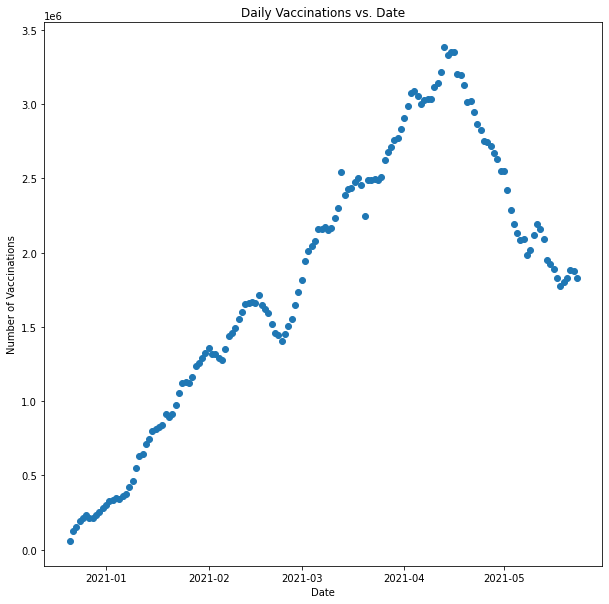

In [ ]:
# plot daily vaccinations in time
plt.figure(figsize=(10,10))
plt.scatter(v_X, v_Y)
plt.title("Daily Vaccinations vs. Date")
plt.xlabel("Date")
plt.ylabel("Number of Vaccinations")
plt.show()

In [ ]:
c_X = cases.loc[:,['date'] ].values
c_Y = cases.loc[:,['new_cases'] ].values

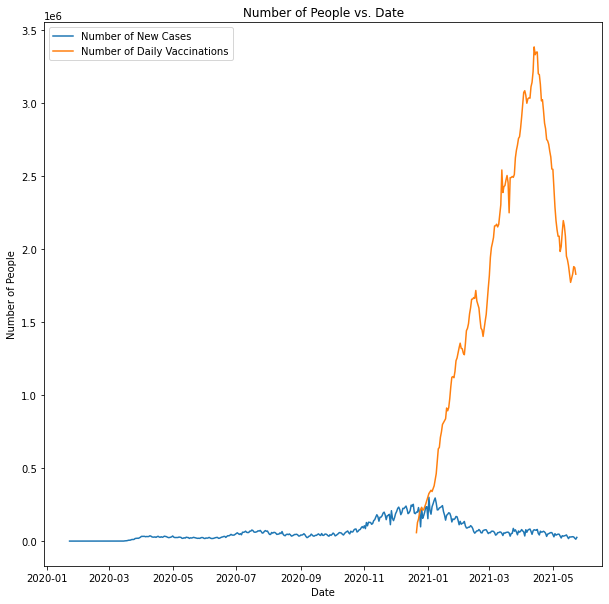

In [ ]:
# Compare cases and vaccinations to determine feature importance
plt.figure(figsize=(10,10))
plt.plot(c_X, c_Y, v_X, v_Y)
plt.legend(["Number of New Cases", "Number of Daily Vaccinations"])
plt.title("Number of People vs. Date")
plt.xlabel("Date")
plt.ylabel("Number of People")
plt.show()

# Preprocessing for Models

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates
import numpy as np
import datetime

In [ ]:
# load relevant data
nyt = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv', index_col= 'fips')

In [ ]:
state_data = pd.read_csv('https://raw.githubusercontent.com/fteng1/CS156b_data/main/covid_state_data.csv', index_col='UID')
state_data

,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,ISO3,Testing_Rate,Hospitalization_Rate
UID,,,,,,,,,,,,,,,,,
84000001.0,Alabama,US,2020-04-12 23:18:15,32.3182,-86.9023,3667,93,NaN,3470.0,1.0,75.988020,21583.0,437.0,2.610160,USA,460.300152,12.264945
84000002.0,Alaska,US,2020-04-12 23:18:15,61.3707,-152.4044,272,8,66.0,264.0,2.0,45.504049,8038.0,31.0,2.941176,USA,1344.711576,11.397059
84000004.0,Arizona,US,2020-04-12 23:18:15,33.7298,-111.4312,3542,115,NaN,3427.0,4.0,48.662422,52289.0,NaN,3.246753,USA,578.522286,NaN
84000005.0,Arkansas,US,2020-04-12 23:18:15,34.9697,-92.3731,1280,27,367.0,1253.0,5.0,49.439423,19722.0,130.0,2.109375,USA,761.753354,10.156250
84000006.0,California,US,2020-04-12 23:18:15,36.1162,-119.6816,22805,643,NaN,22155.0,6.0,58.137726,190328.0,5234.0,2.812020,USA,485.423868,22.961176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84000051.0,Virginia,US,2021-05-22 04:31:30,37.7693,-78.1700,672312,11074,NaN,NaN,51.0,7876.638784,7311041.0,NaN,1.647152,USA,85654.322836,NaN
84000053.0,Washington,US,2021-05-22 04:31:30,47.4009,-121.4905,427494,5702,NaN,NaN,53.0,5613.919985,6882431.0,NaN,1.333820,USA,90381.191174,NaN
84000054.0,West Virginia,US,2021-05-22 04:31:30,38.4912,-80.9545,159735,2772,NaN,NaN,54.0,8913.052333,2897090.0,NaN,1.735374,USA,161654.708012,NaN


In [ ]:
state_data = state_data.loc[:,['Province_State', 'Last_Update', 'Incident_Rate', 'People_Tested'] ]
state_data = state_data.rename(columns={"Province_State": "state", "Last_Update": "date"})
state_data['date'] = (state_data['date'].str[0:10])

In [ ]:
state_data

,state,date,Incident_Rate,People_Tested
UID,,,,
84000001.0,Alabama,2020-04-12,75.988020,21583.0
84000002.0,Alaska,2020-04-12,45.504049,8038.0
84000004.0,Arizona,2020-04-12,48.662422,52289.0
84000005.0,Arkansas,2020-04-12,49.439423,19722.0
84000006.0,California,2020-04-12,58.137726,190328.0
...,...,...,...,...
84000051.0,Virginia,2021-05-22,7876.638784,7311041.0
84000053.0,Washington,2021-05-22,5613.919985,6882431.0
84000054.0,West Virginia,2021-05-22,8913.052333,2897090.0


In [ ]:
nyt

,date,state,cases,deaths
fips,,,,
53,2020-01-21,Washington,1,0
53,2020-01-22,Washington,1,0
53,2020-01-23,Washington,1,0
17,2020-01-24,Illinois,1,0
53,2020-01-24,Washington,1,0
...,...,...,...,...
51,2021-05-23,Virginia,673029,11106
53,2021-05-23,Washington,429526,5747
54,2021-05-23,West Virginia,159735,2772


In [ ]:
vaccines = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/us_state_vaccinations.csv', index_col= 'total_distributed')
vaccines.loc[(vaccines.location == 'New York State'),'location']='New York'
v_features = ['date','people_fully_vaccinated', 'location']
vaccines = vaccines[v_features]
vaccines = vaccines.rename(columns={"location": "state"})
vaccines

,date,people_fully_vaccinated,state
total_distributed,,,
377025.0,2021-01-12,7270.0,Alabama
378975.0,2021-01-13,9245.0,Alabama
435350.0,2021-01-14,NaN,Alabama
444650.0,2021-01-15,13488.0,Alabama
NaN,2021-01-16,NaN,Alabama
...,...,...,...
499235.0,2021-05-20,178309.0,Wyoming
500415.0,2021-05-21,179026.0,Wyoming
501825.0,2021-05-22,180097.0,Wyoming


In [ ]:
nyt.sort_values(by = ['date', 'state'], inplace=True)

In [ ]:
nyt

,date,state,cases,deaths
fips,,,,
53,2020-01-21,Washington,1,0
53,2020-01-22,Washington,1,0
53,2020-01-23,Washington,1,0
17,2020-01-24,Illinois,1,0
53,2020-01-24,Washington,1,0
...,...,...,...,...
51,2021-05-23,Virginia,673029,11106
53,2021-05-23,Washington,429526,5747
54,2021-05-23,West Virginia,159735,2772


In [ ]:
combined = pd.merge(nyt, vaccines, on=['state', 'date'])
combined = pd.merge(combined, state_data, on=['state', 'date'])
combined

,date,state,cases,deaths,people_fully_vaccinated,Incident_Rate,People_Tested
0,2021-01-12,Alabama,407848,5573,7270.0,8239.542257,1972863.0
1,2021-01-12,Alaska,50243,216,5400.0,6888.708145,1357708.0
2,2021-01-12,Arizona,638739,10537,8343.0,8621.588118,5696693.0
3,2021-01-12,Arkansas,259553,4121,8.0,8494.388635,2202491.0
4,2021-01-12,California,2816280,31105,100089.0,6980.171680,36170528.0
...,...,...,...,...,...,...,...
7200,2021-05-22,Virginia,672793,11097,3645792.0,7876.638784,7311041.0
7201,2021-05-22,Washington,429514,5747,3273072.0,5613.919985,6882431.0
7202,2021-05-22,West Virginia,159735,2772,599305.0,8913.052333,2897090.0
7203,2021-05-22,Wisconsin,672476,7748,2503394.0,11540.001999,8621468.0


In [ ]:
grouped = combined.groupby(combined.state)
state = grouped.get_group('New York')
state

,date,state,cases,deaths,people_fully_vaccinated,Incident_Rate,People_Tested
33,2021-01-12,New York,1164819,39588,36422.0,5910.336930,27524906.0
88,2021-01-13,New York,1179523,39760,44512.0,5986.369282,27721577.0
143,2021-01-14,New York,1193710,39997,NaN,6061.954415,27918445.0
198,2021-01-15,New York,1213179,40203,73523.0,6134.881938,28131034.0
253,2021-01-16,New York,1229124,40376,NaN,6234.961301,28455705.0
...,...,...,...,...,...,...,...
6963,2021-05-18,New York,2086577,52480,8370512.0,10727.269933,53963868.0
7018,2021-05-19,New York,2087900,52505,8450267.0,10735.109114,54065041.0
7073,2021-05-20,New York,2089547,52531,8522398.0,10741.981892,54160911.0
7128,2021-05-21,New York,2091142,52555,8613844.0,10750.432787,54303681.0


In [ ]:
# save dates to be used later
dates_original = state['date']
dates_original

33      2021-01-12
88      2021-01-13
143     2021-01-14
198     2021-01-15
253     2021-01-16
           ...    
6963    2021-05-18
7018    2021-05-19
7073    2021-05-20
7128    2021-05-21
7183    2021-05-22
Name: date, Length: 131, dtype: object

# Random Forest Regressor

Used Random Forest Regressor and tested at different tree depths.

In [ ]:
grouped = combined.groupby(combined.state)

states = ['Alaska', 'Alabama', 'Arkansas', 'Arizona', 'California', 'Colorado', 'Connecticut', 'Delaware', 
          'Florida', 'Georgia', 'Hawaii', 'Iowa', 'Idaho', 'Illinois', 'Indiana', 'Kansas', 'Kentucky', 'Louisiana', 
          'Massachusetts', 'Maryland', 'Maine', 'Michigan', 'Minnesota', 'Missouri', 'Mississippi', 'Montana', 
          'North Carolina', 'North Dakota', 'Nebraska', 'New Hampshire', 'New Jersey', 'New Mexico', 'Nevada', 
          'New York', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina', 
          'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Virginia', 'Vermont', 'Washington', 'Wisconsin', 
          'West Virginia', 'Wyoming']

scores = []
state_scores = [[] for _ in range(len(states))]
tree_depths = [1, 2, 3, 4, 5, 10, 15, 20, 25]
for levels in tree_depths:
  av = 0
  for i, s in enumerate(states):
    state.is_copy = None
    state = grouped.get_group(s).copy()
    state['date'] = (state['date'].str[5:7] + state['date'].str[-2::]).astype(int)
    state = state.dropna()

    n_estimators = 500
    rgr = RandomForestRegressor(n_estimators = n_estimators, max_depth=levels)
    features = ['cases', 'deaths', 'Incident_Rate', "People_Tested"]
    state = state.drop(['state'],axis=1)
    # standardization
    scaler = StandardScaler()
    scaler.fit(state.values.tolist())
    scaler.transform(state.values.tolist())

    X = state.loc[:, features].values
    Y = state.loc[:,['people_fully_vaccinated']].values.ravel()
    # state.is_copy = None
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=10)
    rgr.fit(X_train, Y_train)
    results = rgr.score(X_test, Y_test)
    state_scores[i].append(results)
    av += results
    # print(s + ": " + str(results) + "\n")
  scores.append(av / len(states))
  print("Average for {l} levels: ".format(l=levels) + str(av / len(states)) + "\n")

In [ ]:
# Plot score vs max tree depth to determine best tree depth
for st in state_scores:
  plt.plot(tree_depths, st)
plt.title("Score vs. Maximum Tree Depth")
plt.xlabel("Maximum Tree Depth")
plt.ylabel("Score")
plt.legend(states, loc='lower right', fontsize='xx-small', ncol=3)
plt.show()

# Linear Models

Used Linear Models including logistic regression, linear regression, ridge regression, lass regression, lasso lars regression, and Bayesian regression. 

In [ ]:
from sklearn import linear_model

In [ ]:

models = [linear_model.LogisticRegression(random_state=0, max_iter=1200000, class_weight='balanced'), linear_model.LinearRegression(), linear_model.Ridge(alpha=.5), linear_model.Lasso(alpha=0.5),linear_model.LassoLars(alpha=0.5), linear_model.BayesianRidge()]
# testing for all models 
for m in models:
  state.is_copy = None
  s = 'California'
  state = grouped.get_group(s).copy()
  state['date'] = (state['date'].str[5:7] + state['date'].str[-2::]).astype(int)
  state = state.dropna()
  state=state.drop(['state'],axis=1)

  rgr = m
  features = ['people_fully_vaccinated','deaths', 'Incident_Rate', 'People_Tested']

  X = state.loc[:, features].values


  Y = state.loc[:,['cases']].values.ravel()
  # state.is_copy = None
  scaler = StandardScaler()
  scaler.fit(state.values.tolist())
  scaler.transform(state.values.tolist())
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=10)
  rgr.fit(X_train, Y_train)
  results = rgr.score(X_test, Y_test)
  print(str(m) + ": " + str(results) + "\n")

# LSTM Preprocessing

Further Preprocessing for LSTM model 

In [ ]:
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np
from pandas import DataFrame
from pandas import concat
import keras
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:

state = state.drop(['state'], axis=1)
state

,date,cases,deaths,people_fully_vaccinated,Incident_Rate,People_Tested
33,2021-01-12,1164819,39588,36422.0,5910.336930,27524906.0
88,2021-01-13,1179523,39760,44512.0,5986.369282,27721577.0
143,2021-01-14,1193710,39997,NaN,6061.954415,27918445.0
198,2021-01-15,1213179,40203,73523.0,6134.881938,28131034.0
253,2021-01-16,1229124,40376,NaN,6234.961301,28455705.0
...,...,...,...,...,...,...
6963,2021-05-18,2086577,52480,8370512.0,10727.269933,53963868.0
7018,2021-05-19,2087900,52505,8450267.0,10735.109114,54065041.0
7073,2021-05-20,2089547,52531,8522398.0,10741.981892,54160911.0
7128,2021-05-21,2091142,52555,8613844.0,10750.432787,54303681.0


In [ ]:
# features used
features = ['people_fully_vaccinated', 'deaths', 'Incident_Rate', "People_Tested"]
# convert date into numerical form
state['date'] = (state['date'].str[5:7] + state['date'].str[-2::]).astype(int)

X = state.loc[:, features].values
Y = state.loc[:,['cases']].values.ravel()
# split into test and train
train_X, test_X, train_y, test_y = train_test_split(X, Y, test_size=0.25, random_state=10)

In [ ]:
values = np.concatenate((X, Y[:, None]), axis=1)


# Efficacy

Weighted efficacy calculation combined for Pfizer, Moderna, and Pfizer

In [ ]:
bymanufact = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/4ceb48bc25c4022b501aedab368565e054de3069/public/data/vaccinations/vaccinations-by-manufacturer.csv', index_col= 'date')

In [ ]:

group = bymanufact.groupby(bymanufact.location)
bymanufact = group.get_group('United States')
bymanufact =bymanufact.tail(3)
# cumulative vaccinations
bymanufact


,location,vaccine,total_vaccinations
date,,,
2021-05-23,United States,Johnson&Johnson,10265423
2021-05-23,United States,Moderna,121125577
2021-05-23,United States,Pfizer/BioNTech,154119424


In [ ]:
moderna=0
pfizer=0
jj=0
for index, row in bymanufact.iterrows():
    if row['vaccine'] == 'Moderna':
      moderna += row['total_vaccinations']
    elif row['vaccine'] == 'Pfizer/BioNTech':
      pfizer += row['total_vaccinations']
    else:
      jj += row['total_vaccinations']
total = moderna + pfizer + jj
w_mod = moderna/total
w_pfi = pfizer/total
w_jj = jj/total
# calculates weighted efficacy by proportion of population using which of the three vaccines 
weighted_eff= w_mod * 0.941 + w_pfi * 0.95 + w_jj * 0.72
print(weighted_eff)

0.9379122540093316


In [ ]:
# get state population
population = pd.read_csv('https://raw.githubusercontent.com/fteng1/CS156b_data/main/csvData.csv')

In [ ]:
population

,rank,State,Pop,Growth,Pop2018,Pop2010,growthSince2010,Percent,density
0,1,California,39613500,0.0038,39461600,37319500,0.0615,0.1184,254.2929
1,2,Texas,29730300,0.0385,28628700,25242000,0.1778,0.0889,113.8080
2,3,Florida,21944600,0.0330,21244300,18845500,0.1644,0.0656,409.2233
3,4,New York,19300000,-0.0118,19530400,19399900,-0.0051,0.0577,409.5404
4,5,Pennsylvania,12804100,0.0002,12800900,12711200,0.0073,0.0383,286.1699
5,6,Illinois,12569300,-0.0121,12723100,12840500,-0.0211,0.0376,226.3964
6,7,Ohio,11714600,0.0033,11676300,11539300,0.0152,0.0350,286.6939
7,8,Georgia,10830000,0.0303,10511100,9711880,0.1151,0.0324,188.3053
8,9,North Carolina,10701000,0.0308,10381600,9574320,0.1177,0.0320,220.1037
9,10,Michigan,9992430,0.0008,9984070,9877510,0.0116,0.0299,176.7352


In [ ]:
# stores state to state population in dictionary 
dic = {}
for index, row in population.iterrows():
  dic[row['State']] = math.ceil(row['Pop'])
print(dic)

{'California': 39613500, 'Texas': 29730300, 'Florida': 21944600, 'New York': 19300000, 'Pennsylvania': 12804100, 'Illinois': 12569300, 'Ohio': 11714600, 'Georgia': 10830000, 'North Carolina': 10701000, 'Michigan': 9992430, 'New Jersey': 8874520, 'Virginia': 8603980, 'Washington': 7796940, 'Arizona': 7520100, 'Tennessee': 6944260, 'Massachusetts': 6912240, 'Indiana': 6805660, 'Missouri': 6169040, 'Maryland': 6065440, 'Colorado': 5893630, 'Wisconsin': 5852490, 'Minnesota': 5706400, 'South Carolina': 5277830, 'Alabama': 4934190, 'Louisiana': 4627000, 'Kentucky': 4480710, 'Oregon': 4289440, 'Oklahoma': 3990440, 'Connecticut': 3552820, 'Utah': 3310770, 'Puerto Rico': 3194370, 'Nevada': 3185790, 'Iowa': 3167970, 'Arkansas': 3033950, 'Mississippi': 2966410, 'Kansas': 2917220, 'New Mexico': 2105000, 'Nebraska': 1952000, 'Idaho': 1860120, 'West Virginia': 1767860, 'Hawaii': 1406430, 'New Hampshire': 1372200, 'Maine': 1354520, 'Montana': 1085000, 'Rhode Island': 1061510, 'Delaware': 990334, 'Sou

# Final LSTM

Final LSTM used for predictions of cases using vaccinations, incident rates, deaths, people tested

In [ ]:
state

,date,state,cases,deaths,people_fully_vaccinated,Incident_Rate,People_Tested
33,2021-01-12,New York,1164819,39588,36422.0,5910.336930,27524906.0
88,2021-01-13,New York,1179523,39760,44512.0,5986.369282,27721577.0
143,2021-01-14,New York,1193710,39997,NaN,6061.954415,27918445.0
198,2021-01-15,New York,1213179,40203,73523.0,6134.881938,28131034.0
253,2021-01-16,New York,1229124,40376,NaN,6234.961301,28455705.0
...,...,...,...,...,...,...,...
6963,2021-05-18,New York,2086577,52480,8370512.0,10727.269933,53963868.0
7018,2021-05-19,New York,2087900,52505,8450267.0,10735.109114,54065041.0
7073,2021-05-20,New York,2089547,52531,8522398.0,10741.981892,54160911.0
7128,2021-05-21,New York,2091142,52555,8613844.0,10750.432787,54303681.0


In [ ]:
features = ['people_fully_vaccinated', 'deaths', 'Incident_Rate', "People_Tested"]

X = state.loc[:, features].values
Y = state.loc[:,['cases']].values.ravel()
# state.is_copy = None
# train_X, test_X, train_y, test_y = train_test_split(X, Y, test_size=0.25, random_state=10)

In [ ]:
values = np.concatenate((X, Y[:, None]), axis=1)

In [ ]:
# performs LSTM with lookup of 1
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, labels = list(), list()
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		labels += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			labels += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			labels += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	tbl = concat(cols, axis=1)
	tbl.columns = labels
	if dropnan:
		tbl.dropna(inplace=True)
	return tbl

values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)
reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000936,0.013247,0.015683,0.007294,0.015851
8,0.007609,0.103589,0.112602,0.060849,0.112253,0.008145,0.120148,0.126090,0.067423,0.124239
9,0.008145,0.120148,0.126090,0.067423,0.124239,0.009762,0.135551,0.137879,0.074670,0.139232
10,0.009762,0.135551,0.137879,0.074670,0.139232,0.012215,0.149569,0.152626,0.082999,0.156140
11,0.012215,0.149569,0.152626,0.082999,0.156140,0.014608,0.162199,0.169255,0.092937,0.171134
...,...,...,...,...,...,...,...,...,...,...
126,0.958566,0.990527,0.992113,0.974698,0.991994,0.964214,0.992914,0.993554,0.980497,0.993663
127,0.964214,0.992914,0.993554,0.980497,0.993663,0.973441,0.994840,0.995170,0.984249,0.995090
128,0.973441,0.994840,0.995170,0.984249,0.995090,0.981787,0.996842,0.996588,0.987805,0.996865
129,0.981787,0.996842,0.996588,0.987805,0.996865,0.992366,0.998691,0.998331,0.993099,0.998585


In [ ]:
# reorganizes shape of data to fit into LSTM model
values = reframed.values
# n_days = 100
train = values[:]
# test = values[n_days:, :]
train_X, train_y = train[:, :-5], train[:, -5:]
# test_X, test_y = test[:, :-5], test[:, -5:]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
# test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape) #, test_X.shape, test_y.shape)

(122, 1, 5) (122, 5)


In [ ]:
# Uses LSTM model with 100 nodes and 1 dense layer 
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
# model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(Dense(1))
model.compile(loss='mae', optimizer='sgd')
history = model.fit(train_X, train_y, epochs=150, batch_size=5, verbose=2, shuffle=False)
plt.plot(history.history['loss'], label='train')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# LSTM Predictions

In [ ]:
# predicts new dates using original dates
def predict_dates(num_prediction):
    state['date'] = dates_original
    # print(dates_o)
    last_date = dates_original.values[-1]
    print(last_date)
    prediction_dates = pd.date_range(last_date, periods=num_prediction).tolist()
    return prediction_dates

In [ ]:
target = dic['New York']
print(target)
test_predictions = []
current_batch = train_X[-5:]
iter = 0
pred_final =0
# predict future cases until convergence or until 1 year has been reached
while pred_final < target and iter <= 365:
  # print(current_batch, model.predict(current_batch))
  pred = model.predict(current_batch).reshape(1, 5)
  pred_final = scaler.inverse_transform(pred.reshape(1, 5))[0][4]
  test_predictions.append(pred_final)
  # checks convergence, if converges stop 
  if iter > 1 and test_predictions[iter - 1] == test_predictions[iter]: 
    print(iter)
    break
  current_batch = np.append(current_batch[1:],
                          [pred], axis=0)
  iter+=1

predicted_dates = predict_dates(iter+1)
print(predicted_dates[-1])
print(test_predictions[0],test_predictions[-1])


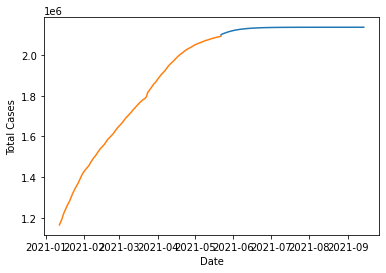

In [ ]:
# Plot recorded cases and predicted cases for New York
plt.plot(predicted_dates, test_predictions)
prev_dates = pd.date_range(state['date'].values[0], periods=len(Y)).tolist()
plt.plot(prev_dates, Y)
# plt.axhline(y=target, color='r', linestyle='-.')
plt.xlabel('Date')
plt.ylabel('Total Cases')
plt.show()

724357
0.10376189675809028
2021-05-22
2022-04-28 00:00:00
69597.72 75160.66


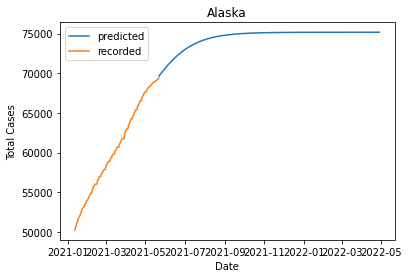

4934190
0.10678499155889822
2021-05-22
2021-11-15 00:00:00
539020.94 526897.44


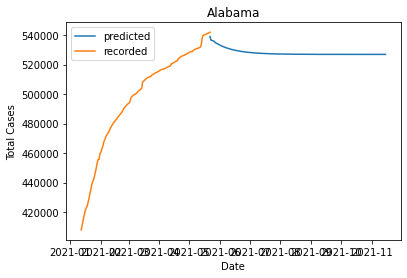

3033950
0.11330073007135912
2021-05-22
2021-10-14 00:00:00
340387.2 343748.75


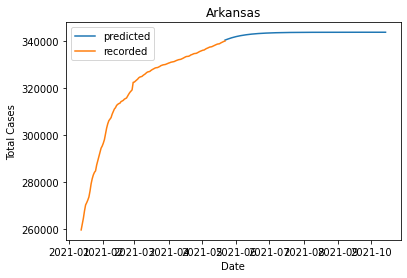

7520100
0.11330416151380966
2021-05-22
2021-11-02 00:00:00
871372.56 852058.6


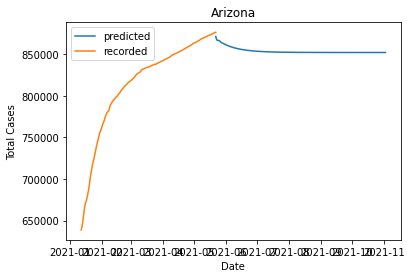

39613500
0.0990862521615106
2021-05-22
2022-01-02 00:00:00
3788478.5 3925153.2


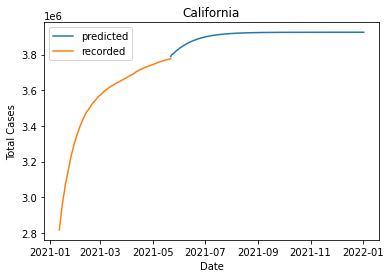

5893630
0.09788114455776831
2021-05-22
2022-02-02 00:00:00
541809.1 576875.25


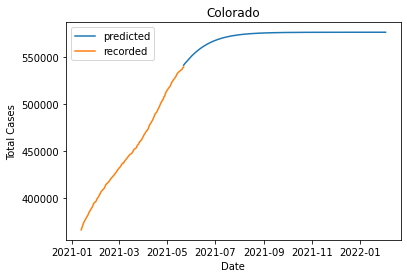

3552820
0.10270205252447352
2021-05-22
2021-11-24 00:00:00
348440.06 364881.9


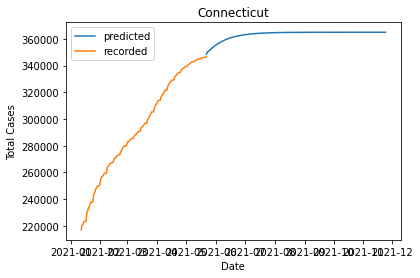

990334
0.10454803000805789
2021-05-22
2022-01-27 00:00:00
107488.31 103537.47


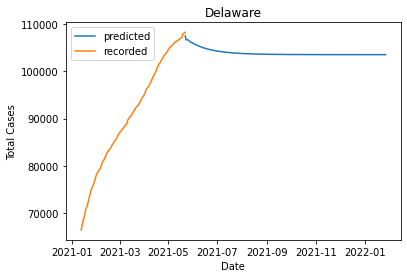

21944600
0.10267908733811507
2021-05-22
2021-12-28 00:00:00
2298047.8 2253251.5


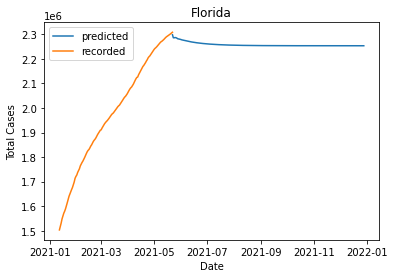

10830000
0.10383010156971376
2021-05-22
2021-11-11 00:00:00
1097864.0 1124480.0


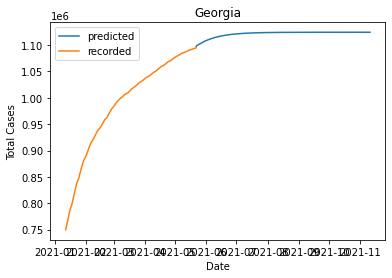

1406430
2021-05-22
2022-05-23 00:00:00
34394.906 31968.674


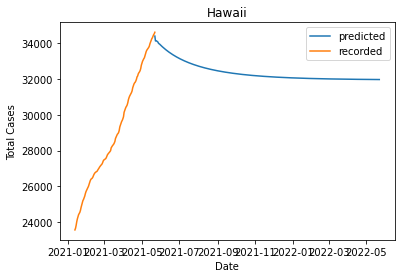

3167970
0.11879528728176088
2021-05-22
2021-10-22 00:00:00
371168.44 376339.9


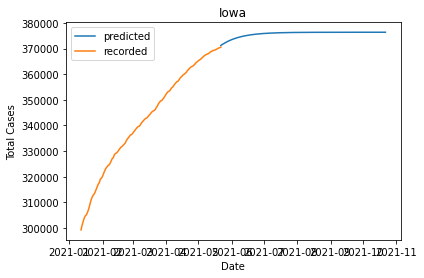

1860120
0.10639255632701117
2021-05-22
2021-12-13 00:00:00
191808.64 197902.92


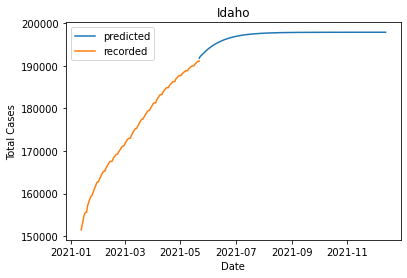

12569300
0.11368867995831113
2021-05-22
2022-01-11 00:00:00
1381555.5 1428987.1


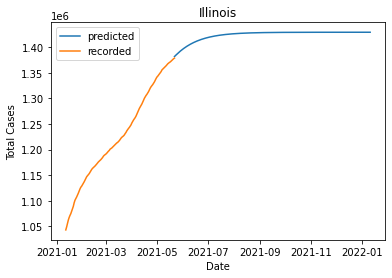

6805660
2021-05-22
2022-05-23 00:00:00
739938.7 711127.0


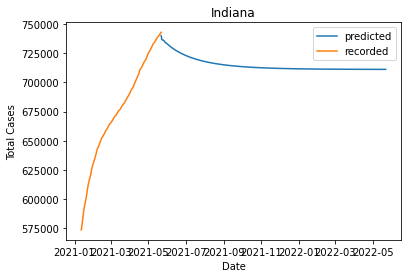

2917220
0.11155071223630716
2021-05-22
2021-11-23 00:00:00
316152.16 325417.97


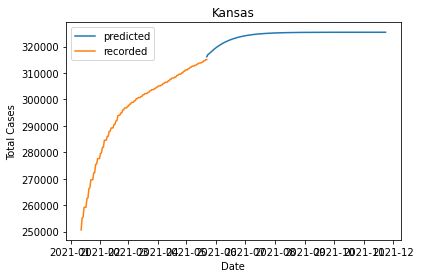

4480710
2021-05-22
2022-05-23 00:00:00
455669.72 238318.14


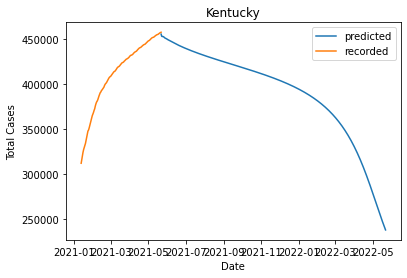

4627000
0.10410418467689647
2021-05-22
2021-11-13 00:00:00
469440.47 481690.06


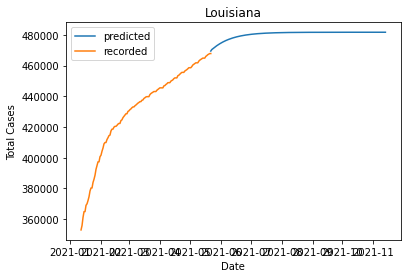

6912240
0.11088993039882875
2021-05-22
2022-02-01 00:00:00
706160.2 766497.8


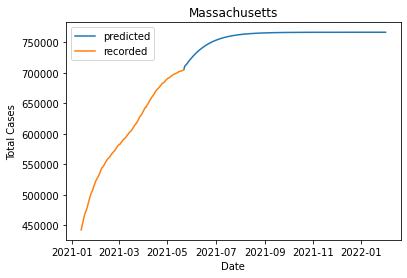

6065440
0.07939074185055
2021-05-22
2021-11-27 00:00:00
460416.6 481539.78


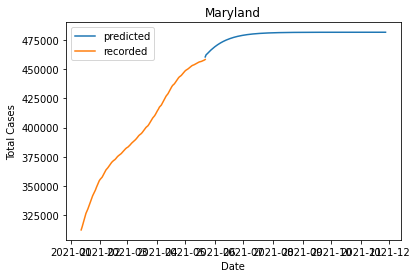

1354520
0.04896330319042908
2021-05-22
2021-10-22 00:00:00
66597.945 66321.77


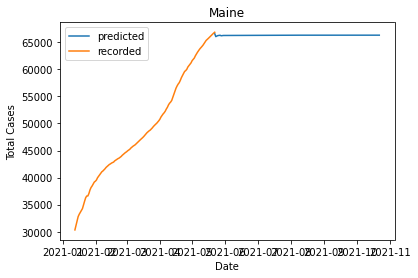

9992430
2021-05-22
2022-05-23 00:00:00
988469.5 1099920.1


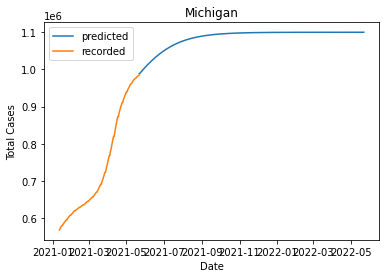

5706400
2021-05-22
2022-05-23 00:00:00
595303.3 573628.94


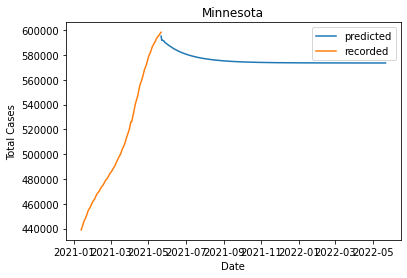

6169040
0.09698729461958425
2021-05-22
2022-02-14 00:00:00
610091.56 598318.5


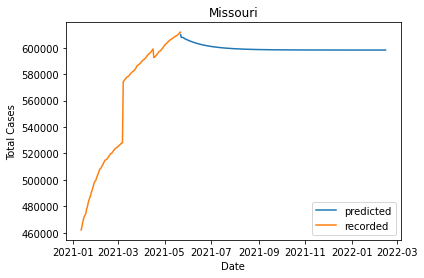

2966410
0.10914561919963862
2021-05-22
2021-09-21 00:00:00
317686.2 323770.66


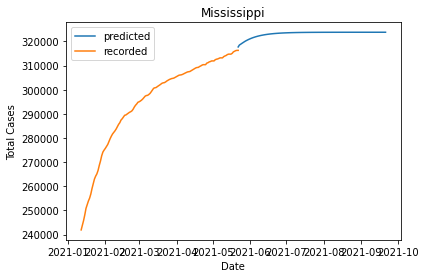

1085000
0.10088600230414746
2021-05-22
2021-10-18 00:00:00
110882.17 109461.31


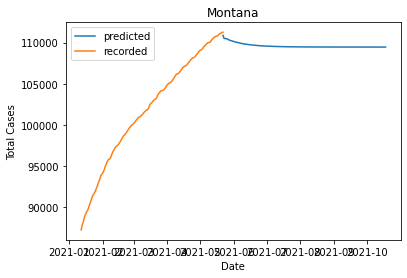

10701000
0.09562307845061209
2021-05-22
2021-11-19 00:00:00
999411.4 1023262.56


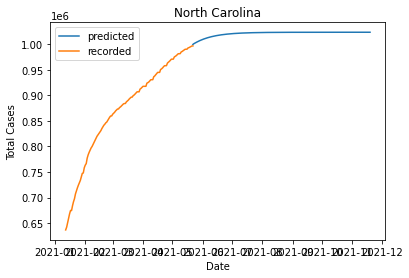

770026
2021-05-22
2022-05-23 00:00:00
109344.95 102717.48


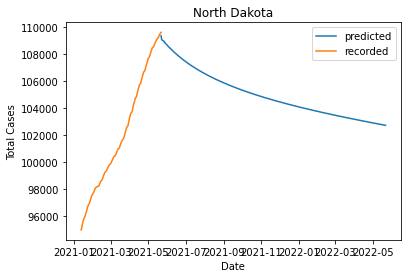

1952000
0.11612512006915984
2021-05-22
2021-11-14 00:00:00
223084.7 226676.23


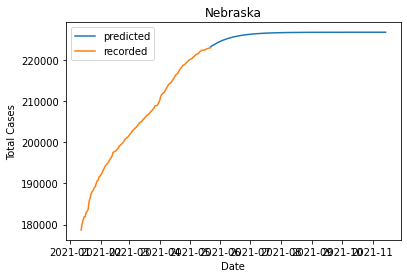

1372200
0.07102796262388865
2021-05-22
2021-08-25 00:00:00
97969.77 97464.57


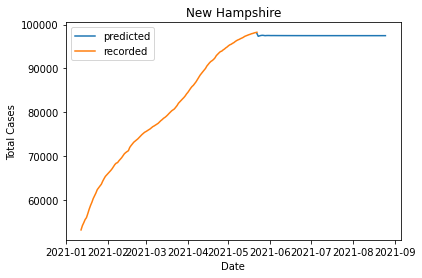

8874520
0.10845861240945989
2021-05-22
2021-12-11 00:00:00
1005433.0 962518.1


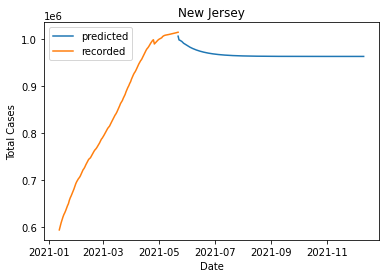

2105000
0.09916932897862232
2021-05-22
2021-11-22 00:00:00
202729.33 208751.44


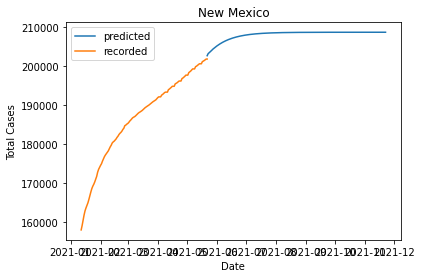

3185790
0.10462554028984962
2021-05-22
2021-12-09 00:00:00
323424.88 333315.0


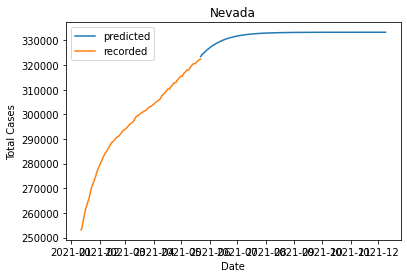

19300000
0.11194237046632124
2021-05-22
2021-10-31 00:00:00
2100423.8 2160487.8


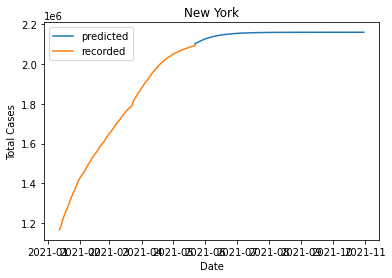

11714600
0.09566425656872621
2021-05-22
2021-10-15 00:00:00
1100194.2 1120668.5


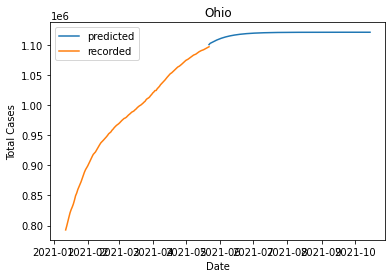

3990440
0.11097249770701978
2021-05-22
2022-03-01 00:00:00
450308.22 442829.1


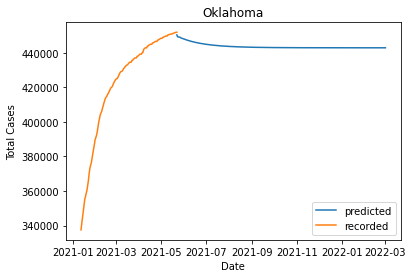

4289440
0.044879579997622064
2021-05-22
2022-02-10 00:00:00
197111.17 192508.27


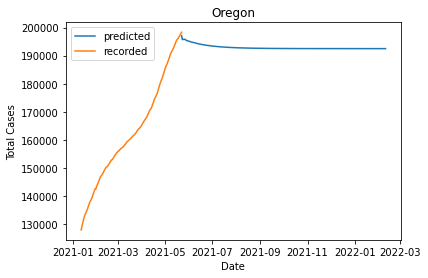

12804100
0.10038858646839684
2021-05-22
2022-01-15 00:00:00
1204383.6 1285385.5


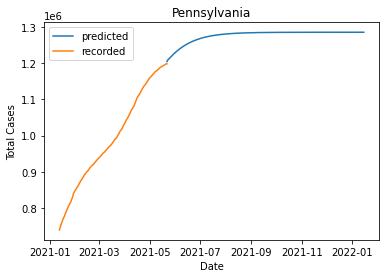

3194370
0.05358171173032554
2021-05-22
2021-12-26 00:00:00
171038.66 171159.81


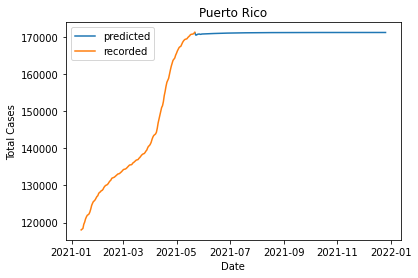

1061510
0.1512691972991305
2021-05-22
2022-01-18 00:00:00
152133.08 160573.77


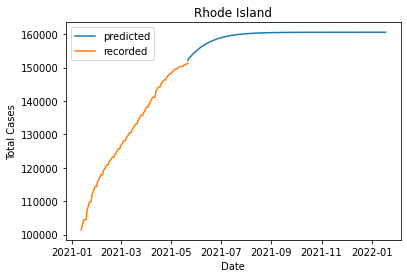

5277830
0.11699570420040055
2021-05-22
2021-10-12 00:00:00
594641.94 617483.44


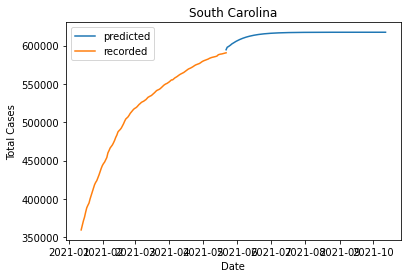

896581
0.13600983730137042
2021-05-22
2022-03-27 00:00:00
123686.72 121943.836


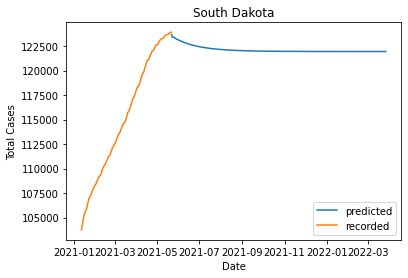

6944260
0.11883168616958466
2021-05-22
2021-11-22 00:00:00
841945.44 825198.1


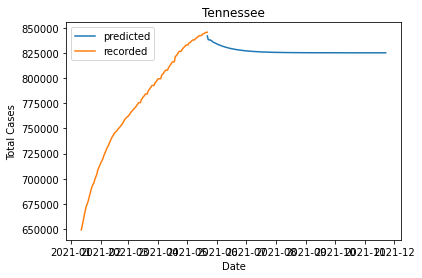

29730300
0.09496459840633965
2021-05-22
2021-12-29 00:00:00
2924151.0 2823326.0


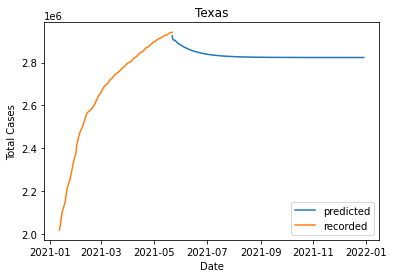

3310770
0.12189101779948472
2021-05-22
2021-10-23 00:00:00
403919.97 403553.12


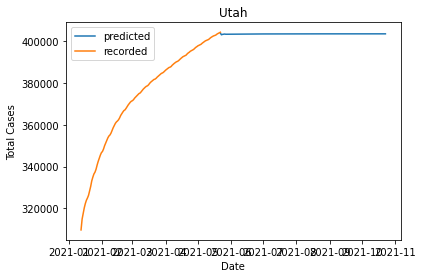

8603980
2021-05-22
2022-05-23 00:00:00
666918.6 604701.25


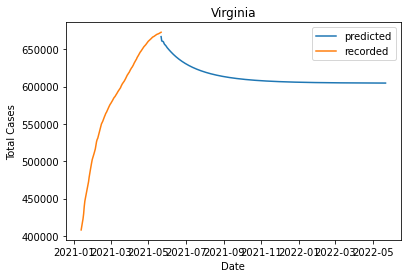

623251
0.04373657994531898
2021-05-22
2021-12-13 00:00:00
24401.416 27258.867


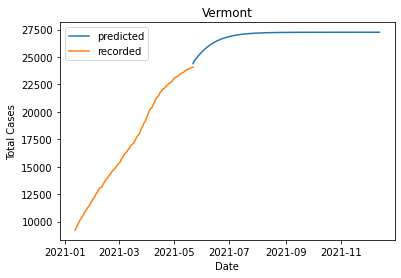

7796940
0.06175915246878904
2021-05-22
2022-03-31 00:00:00
431885.5 481532.4


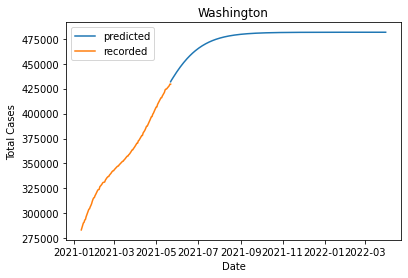

5852490
0.11263497460055463
2021-05-22
2021-12-27 00:00:00
670296.6 659195.06


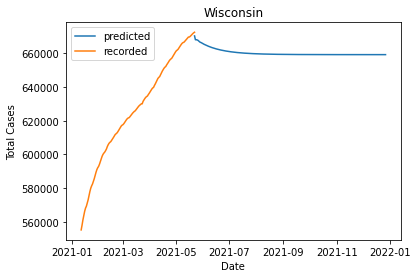

1767860
0.09670011518163203
2021-05-22
2022-01-22 00:00:00
160527.92 170952.27


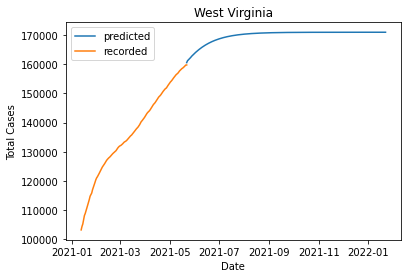

581075
0.10321018021554877
2021-05-22
2021-11-15 00:00:00
59664.613 59972.855


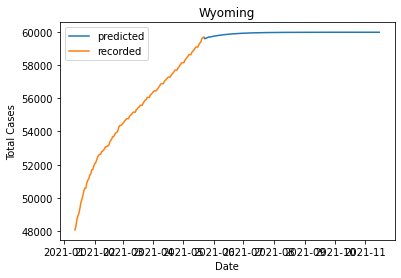

<Figure size 432x288 with 0 Axes>

In [ ]:
# Run LSTM on all states
for s in states:
    state.is_copy = None
    state = grouped.get_group(s).copy()
    # print(state)

    features = ['people_fully_vaccinated', 'deaths', 'Incident_Rate', "People_Tested"]
    # state['date'] = (state['date'].str[5:7] + state['date'].str[-2::]).astype(int)

    X = state.loc[:, features].values
    Y = state.loc[:,['cases']].values.ravel()
  

    values = np.concatenate((X, Y[:, None]), axis=1)
    values = values.astype('float32')
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    reframed = series_to_supervised(scaled, 1, 1)

    values = reframed.values
    # n_days = 100
    train = values[:]
    # test = values[n_days:, :]
    train_X, train_y = train[:, :-5], train[:, -5:]
    # test_X, test_y = test[:, :-5], test[:, -5:]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    # test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    # print(train_X.shape, train_y.shape) #, test_X.shape, test_y.shape)


    model = Sequential()
    model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
    # model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='sgd')
    history = model.fit(train_X, train_y, epochs=150, batch_size=5, verbose=0, shuffle=False)
  
    target = dic[s]
    print(target)
    test_predictions = []
    current_batch = train_X[-5:]
    iter = 0
    # current_batch = first_eval_batch.reshape((1, 5, 5))
    pred_final =0
    while pred_final < target and iter <= 365:
      # print(current_batch, model.predict(current_batch))
      pred = model.predict(current_batch).reshape(1, 5)
      pred_final = scaler.inverse_transform(pred.reshape(1, 5))[0][4]
      test_predictions.append(pred_final)
      # checks convergence, if converges stop 
      if iter > 1 and test_predictions[iter - 1] == test_predictions[iter]: 
        print(test_predictions[iter]/target)
        break
      current_batch = np.append(current_batch[1:],
                              [pred], axis=0)
      iter+=1

    predicted_dates = predict_dates(iter+1)
    print(predicted_dates[-1])
    print(test_predictions[0],test_predictions[-1])
    n =len(predicted_dates)
    m = len(test_predictions) 
    # reorganizes shape for plotting
    if n> m:
      plt.plot(predicted_dates[:m], test_predictions,label = 'predicted')
    elif m> n:
      plt.plot(predicted_dates, test_predictions[:n],label = 'predicted')
    else:
      plt.plot(predicted_dates, test_predictions,label = 'predicted')
    prev_dates = pd.date_range(dates_original.values[0], periods=len(Y)).tolist()
    plt.plot(prev_dates, Y, label='recorded')
    # plt.axhline(y=target, color='r', linestyle='-.', label='threshold')
    plt.xlabel('Date')
    plt.ylabel('Total Cases')
    plt.title(s)
    
    plt.legend()
    plt.show()
    plt.savefig('predictions_for_state.png')

Rerun for states that had cusps in predicted curve.

7520100
0.11779401204771213
2021-05-22
2021-10-10 00:00:00
877223.4 885822.75


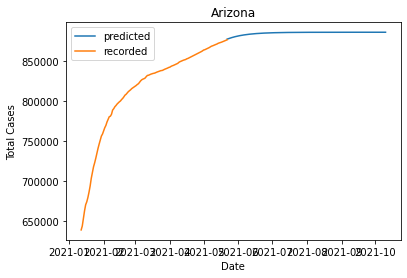

4934190
0.10686339855173797
2021-05-22
2021-11-14 00:00:00
539090.9 527284.3


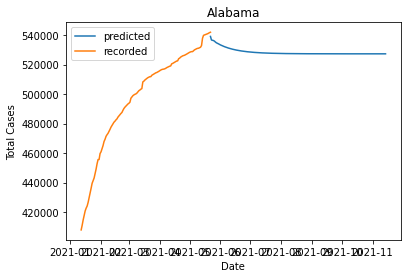

990334
0.1145304497649278
2021-05-22
2021-11-06 00:00:00
108815.31 113423.4


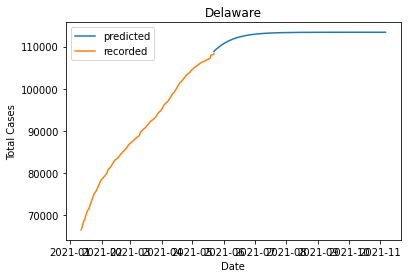

21944600
0.1041427162035307
2021-05-22
2021-11-17 00:00:00
2301571.2 2285370.2


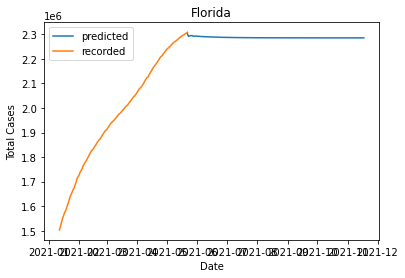

1406430
0.027219826973258535
2021-05-22
2022-02-28 00:00:00
34785.418 38282.78


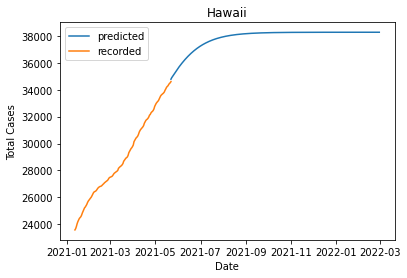

6805660
0.10559998956750705
2021-05-22
2022-05-04 00:00:00
739919.06 718677.6


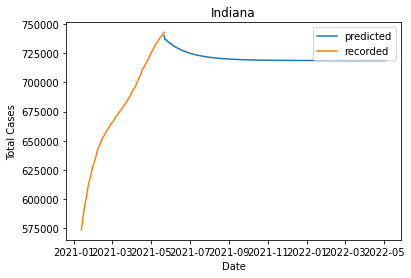

4480710
2021-05-22
2022-05-23 00:00:00
455608.84 438736.53


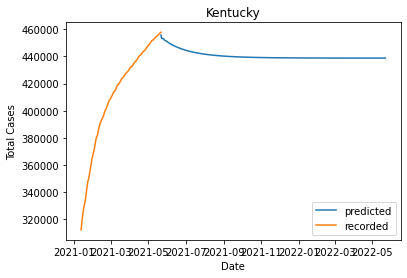

1354520
2021-05-22
2022-05-23 00:00:00
66298.34 62383.348


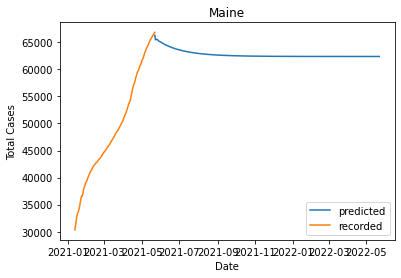

5706400
0.10147744199495304
2021-05-22
2022-05-20 00:00:00
595777.44 579070.9


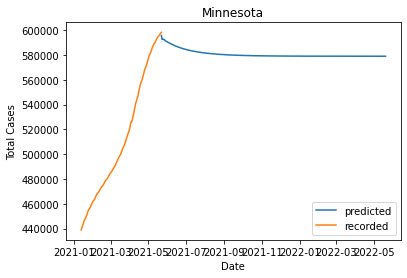

6169040
0.09628064091009297
2021-05-22
2022-03-11 00:00:00
609785.0 593959.1


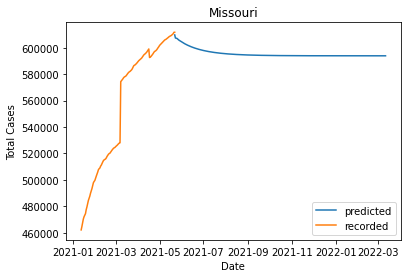

1085000
0.10034699020737327
2021-05-22
2021-11-11 00:00:00
110820.62 108876.484


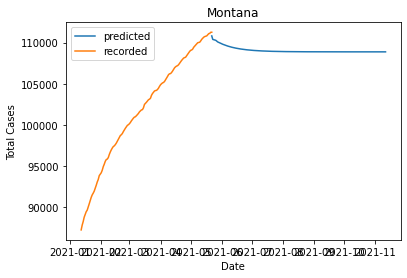

770026
2021-05-22
2022-05-23 00:00:00
109346.81 91057.75


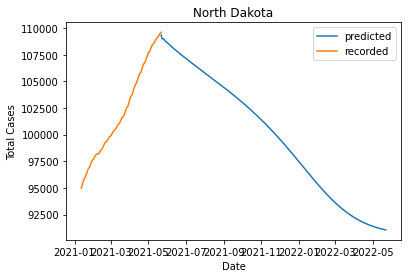

8874520
0.10806186559949157
2021-05-22
2022-01-05 00:00:00
1006081.7 958997.2


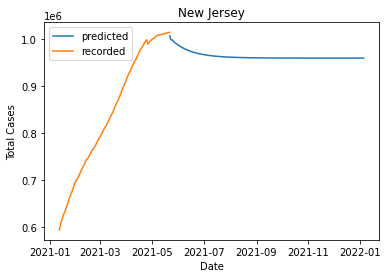

3990440
2021-05-22
2022-05-23 00:00:00
449282.38 414683.62


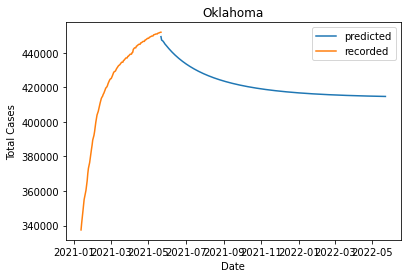

4289440
0.0448452733631896
2021-05-22
2022-02-27 00:00:00
197109.64 192361.11


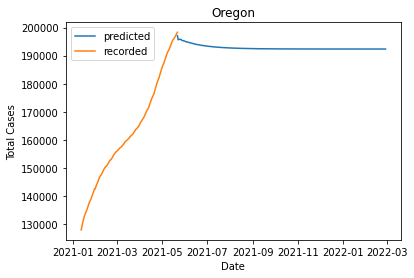

896581
0.1404788893864581
2021-05-22
2021-11-23 00:00:00
124146.86 125950.7


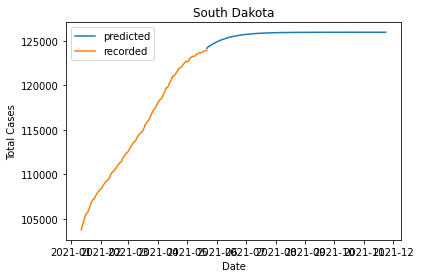

6944260
0.12404172654825713
2021-05-22
2021-10-31 00:00:00
847412.2 861378.0


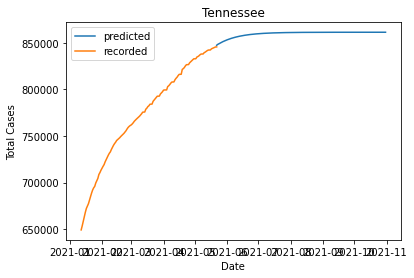

29730300
0.09460148400789767
2021-05-22
2022-01-25 00:00:00
2923642.2 2812530.5


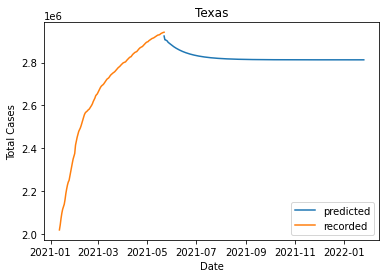

3310770
0.12019705763311858
2021-05-22
2021-12-06 00:00:00
403225.66 397944.8


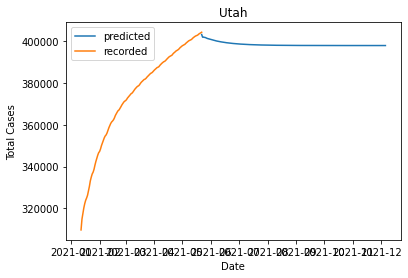

8603980
2021-05-22
2022-05-23 00:00:00
667285.9 518828.75


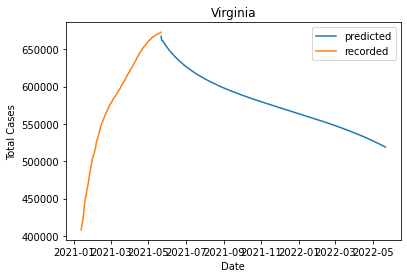

5852490
0.11300434729491209
2021-05-22
2021-11-21 00:00:00
670368.25 661356.8


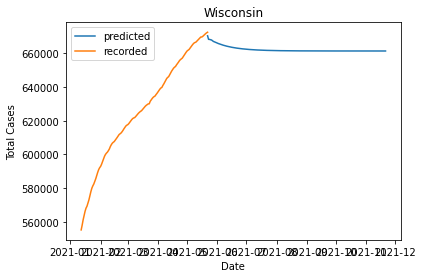

<Figure size 432x288 with 0 Axes>

In [ ]:
for s in ["Arizona", "Alabama", "Delaware", "Florida", "Hawaii", "Indiana", 
          "Kentucky", "Maine", "Minnesota", "Missouri", "Montana", "North Dakota", 
          "New Jersey", "Oklahoma", "Oregon", "South Dakota", "Tennessee", "Texas", 
          "Utah", "Virginia", "Wisconsin"]:
    state.is_copy = None
    state = grouped.get_group(s).copy()
    # print(state)

    features = ['people_fully_vaccinated', 'deaths', 'Incident_Rate', "People_Tested"]
    # state['date'] = (state['date'].str[5:7] + state['date'].str[-2::]).astype(int)

    X = state.loc[:, features].values
    Y = state.loc[:,['cases']].values.ravel()
    # state.is_copy = None
    # train_X, test_X, train_y, test_y = train_test_split(X, Y, test_size=0.25, random_state=10)

    values = np.concatenate((X, Y[:, None]), axis=1)
    values = values.astype('float32')
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    reframed = series_to_supervised(scaled, 1, 1)

    values = reframed.values
    # n_days = 100
    train = values[:]
    # test = values[n_days:, :]
    train_X, train_y = train[:, :-5], train[:, -5:]
    # test_X, test_y = test[:, :-5], test[:, -5:]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    # test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    # print(train_X.shape, train_y.shape) #, test_X.shape, test_y.shape)


    model = Sequential()
    model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
    # model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='sgd')
    history = model.fit(train_X, train_y, epochs=150, batch_size=5, verbose=0, shuffle=False)
  


    target = dic[s]
    print(target)
    test_predictions = []
    current_batch = train_X[-5:]
    iter = 0
    # current_batch = first_eval_batch.reshape((1, 5, 5))
    pred_final =0
    while pred_final < target and iter <= 365:
      # print(current_batch, model.predict(current_batch))
      pred = model.predict(current_batch).reshape(1, 5)
      pred_final = scaler.inverse_transform(pred.reshape(1, 5))[0][4]
      test_predictions.append(pred_final)
      if iter > 1 and test_predictions[iter - 1] == test_predictions[iter]: 
        print(test_predictions[iter]/target)
        break
      current_batch = np.append(current_batch[1:],
                              [pred], axis=0)
      iter+=1

    predicted_dates = predict_dates(iter+1)
    print(predicted_dates[-1])
    print(test_predictions[0],test_predictions[-1])
    n =len(predicted_dates)
    m = len(test_predictions) 
    if n> m:
      plt.plot(predicted_dates[:m], test_predictions,label = 'predicted')
    elif m> n:
      plt.plot(predicted_dates, test_predictions[:n],label = 'predicted')
    else:
      plt.plot(predicted_dates, test_predictions,label = 'predicted')
    prev_dates = pd.date_range(dates_original.values[0], periods=len(Y)).tolist()
    plt.plot(prev_dates, Y, label='recorded')
    # plt.axhline(y=target, color='r', linestyle='-.', label='threshold')
    plt.xlabel('Date')
    plt.ylabel('Total Cases')
    plt.title(s)
    
    plt.legend()
    plt.show()
    plt.savefig('predictions_for_state.png')

Rerun for states that had cusps in predicted curve.

4934190
0.10599330259880548
2021-05-22
2021-12-30 00:00:00
538980.1 522991.1


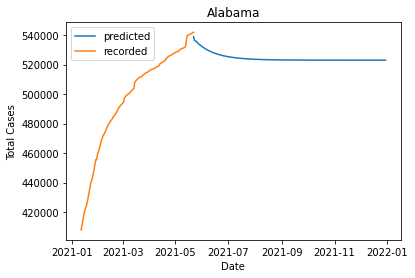

21944600
0.1106527573981754
2021-05-22
2021-11-27 00:00:00
2320660.0 2428230.5


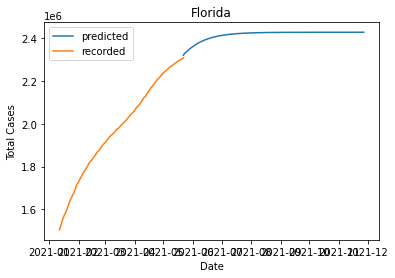

6805660
2021-05-22
2022-05-23 00:00:00
740014.44 710901.9


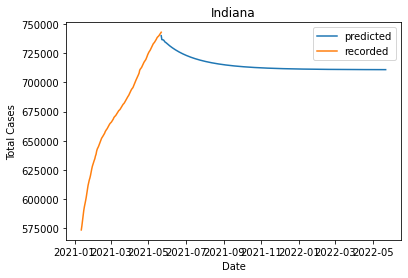

4480710
2021-05-22
2022-05-23 00:00:00
455583.1 233658.53


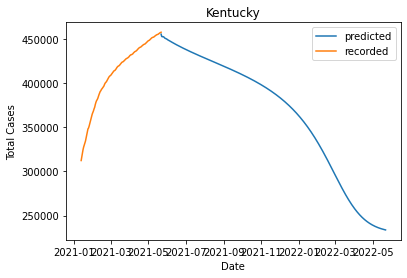

1354520
0.04700150064690813
2021-05-22
2022-02-11 00:00:00
66315.94 63664.473


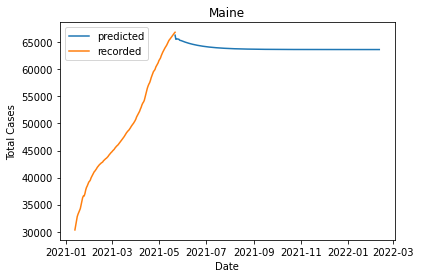

5706400
0.10396404694728725
2021-05-22
2022-02-19 00:00:00
596977.5 593260.44


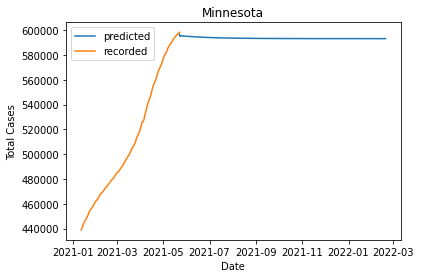

6169040
0.09709983238883198
2021-05-22
2022-01-12 00:00:00
609987.25 599012.75


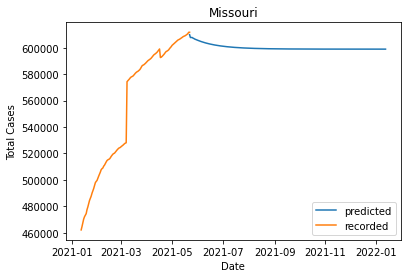

1085000
0.10588001152073732
2021-05-22
2021-11-15 00:00:00
111677.4 114879.81


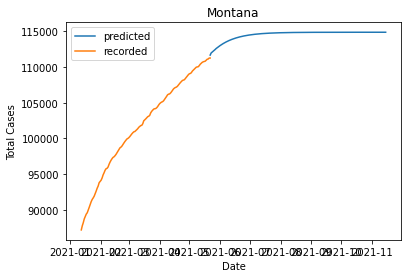

770026
2021-05-22
2022-05-23 00:00:00
109371.4 93799.016


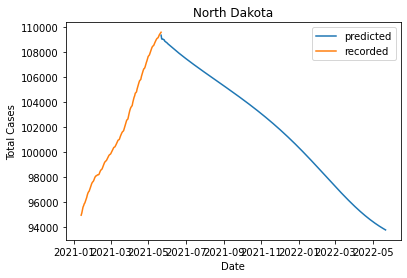

8874520
0.11033572801683922
2021-05-22
2021-10-28 00:00:00
1006992.06 979176.6


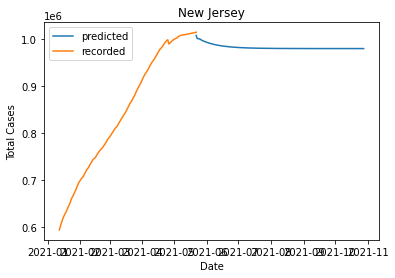

3990440
0.11117781654404026
2021-05-22
2022-03-31 00:00:00
450304.72 443648.4


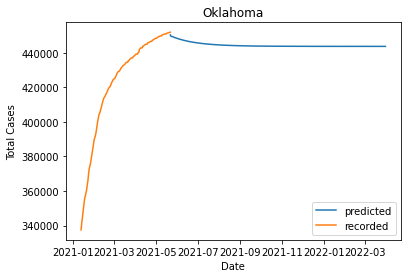

4289440
0.0461656198128427
2021-05-22
2021-11-10 00:00:00
197706.44 198024.66


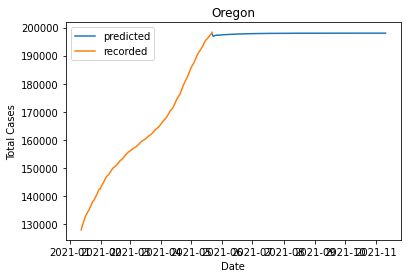

29730300
0.09532593852063383
2021-05-22
2021-11-23 00:00:00
2923510.0 2834068.8


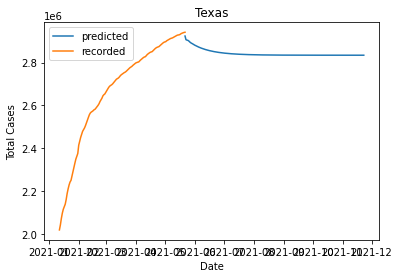

3310770
0.1180288214675136
2021-05-22
2022-02-18 00:00:00
402622.16 390766.28


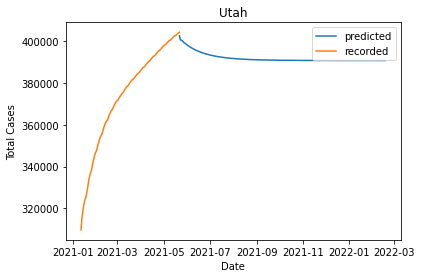

8603980
2021-05-22
2022-05-23 00:00:00
667310.4 623821.6


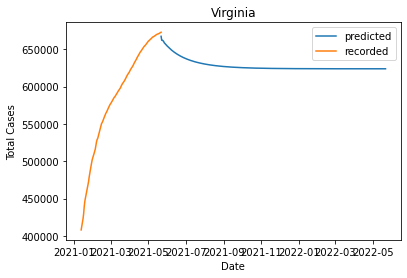

5852490
0.11312976399788807
2021-05-22
2021-11-11 00:00:00
670595.1 662090.8


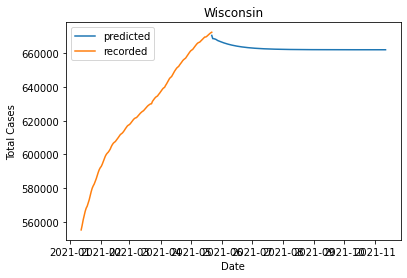

<Figure size 432x288 with 0 Axes>

In [ ]:
for s in ["Alabama", "Florida", "Indiana", "Kentucky", "Maine", "Minnesota", 
          "Missouri", "Montana", "North Dakota", "New Jersey", "Oklahoma", 
          "Oregon", "Texas", "Utah", "Virginia", "Wisconsin"]:
    state.is_copy = None
    state = grouped.get_group(s).copy()
    # print(state)

    features = ['people_fully_vaccinated', 'deaths', 'Incident_Rate', "People_Tested"]
    # state['date'] = (state['date'].str[5:7] + state['date'].str[-2::]).astype(int)

    X = state.loc[:, features].values
    Y = state.loc[:,['cases']].values.ravel()
    # state.is_copy = None
    # train_X, test_X, train_y, test_y = train_test_split(X, Y, test_size=0.25, random_state=10)

    values = np.concatenate((X, Y[:, None]), axis=1)
    values = values.astype('float32')
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    reframed = series_to_supervised(scaled, 1, 1)

    values = reframed.values
    # n_days = 100
    train = values[:]
    # test = values[n_days:, :]
    train_X, train_y = train[:, :-5], train[:, -5:]
    # test_X, test_y = test[:, :-5], test[:, -5:]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    # test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    # print(train_X.shape, train_y.shape) #, test_X.shape, test_y.shape)


    model = Sequential()
    model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
    # model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='sgd')
    history = model.fit(train_X, train_y, epochs=150, batch_size=5, verbose=0, shuffle=False)
  


    target = dic[s]
    print(target)
    test_predictions = []
    current_batch = train_X[-5:]
    iter = 0
    # current_batch = first_eval_batch.reshape((1, 5, 5))
    pred_final =0
    while pred_final < target and iter <= 365:
      # print(current_batch, model.predict(current_batch))
      pred = model.predict(current_batch).reshape(1, 5)
      pred_final = scaler.inverse_transform(pred.reshape(1, 5))[0][4]
      test_predictions.append(pred_final)
      if iter > 1 and test_predictions[iter - 1] == test_predictions[iter]: 
        print(test_predictions[iter]/target)
        break
      current_batch = np.append(current_batch[1:],
                              [pred], axis=0)
      iter+=1

    predicted_dates = predict_dates(iter+1)
    print(predicted_dates[-1])
    print(test_predictions[0],test_predictions[-1])
    n =len(predicted_dates)
    m = len(test_predictions) 
    if n> m:
      plt.plot(predicted_dates[:m], test_predictions,label = 'predicted')
    elif m> n:
      plt.plot(predicted_dates, test_predictions[:n],label = 'predicted')
    else:
      plt.plot(predicted_dates, test_predictions,label = 'predicted')
    prev_dates = pd.date_range(dates_original.values[0], periods=len(Y)).tolist()
    plt.plot(prev_dates, Y, label='recorded')
    # plt.axhline(y=target, color='r', linestyle='-.', label='threshold')
    plt.xlabel('Date')
    plt.ylabel('Total Cases')
    plt.title(s)
    
    plt.legend()
    plt.show()
    plt.savefig('predictions_for_state.png')

In [ ]:
bad = ["Alabama", "Indiana", "Kentucky", "Maine", "Minnesota", "Missouri", "North Dakota", 
       "New Jersey", "Oklahoma", "Texas", "Utah", "Virginia", "Wisconsin"]

# 13 states had wack results after running 3 times
# rest converged

# Previous LSTM 1

Previous LSTM used, deprecated

In [ ]:
look_back = 15
train_generator = TimeseriesGenerator(train, train, length=look_back, batch_size=1)    
# test_generator = TimeseriesGenerator(test_X, test_y, length=look_back, batch_size=1)
print(train[0])
print(train[1])

[0.         0.         0.         0.         0.         0.01585102
 0.01324701 0.01568258 0.00729358 0.00093597]
[0.11225307 0.10358906 0.112602   0.06084943 0.00760869 0.12423944
 0.12014794 0.12608981 0.06742346 0.00814483]


In [ ]:
X_vals = []
Y_vals = []
# print(train_generator[0][0][0][0])
for i in range(len(train_generator)):
  X_vals.append(train_generator[i][0][0][0])
  Y_vals.append(train_generator[i][1][0])

X_vals = np.array(X_vals)
Y_vals = np.array(Y_vals)
print(X_vals[0])
print(Y_vals[0])

[0.         0.         0.         0.         0.         0.01585102
 0.01324701 0.01568258 0.00729358 0.00093597]
[0.29346204 0.3031423  0.2958908  0.17845011 0.03664124 0.30117416
 0.31569624 0.30431902 0.18402028 0.03836823]


In [ ]:
# from sklearn import svm

# model=Sequential()
# model.add(LSTM(100,activation='relu', input_shape=(look_back,5),return_sequences=True))
# model.add(LSTM(50,activation='relu',return_sequences=True))
# model.add(LSTM(10,activation='relu'))
# model.add(Dense(5))


model = Sequential()
model.add(
    LSTM(10,
        activation='relu',
        input_shape=(look_back,5))
       
)
model.add(Dense(5))
# model.summary()
model.compile(optimizer='adam', loss='mse')
# n_estimators = 500
# model = linear_model.LogisticRegression()
# model = RandomForestRegressor(n_estimators = n_estimators, max_depth=10, min_samples_leaf=5)
# model = svm.SVR()
# model.fit(X_vals, Y_vals)

num_epochs = 25
model.fit(train_generator, epochs=num_epochs)

In [ ]:
def predict_dates(num_prediction):
    state['date'] = dates
    last_date = state['date'].values[-1]

    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates

In [ ]:
test_predictions = []
first_eval_batch = train[-look_back:]
current_batch = first_eval_batch.reshape((1, look_back, 5))
# print(model.predict(current_batch))
for i in range(len(test_X)):
  pred = model.predict(current_batch)
  test_predictions.append(pred[0][4])
  current_batch = np.append(current_batch[:,1:,:],
                          [pred],
                          axis=1)
predicted_dates = predict_dates(len(test_X)-1)
predicted_dates
test_predictions

In [ ]:
plt.plot(predicted_dates, test_predictions)
# plt.plot(dates, Y)


In [ ]:
# test_generator = TimeseriesGenerator(test_X, test_y, length=look_back, batch_size=1)
# prediction = model.predict(test_generator)

train_X = train_X.reshape((-1))
test_X =test_X.reshape((-1))
test_y = test_y.reshape((-1))
values= values.reshape((-1))
def predict(num_prediction, model):
    prediction_list = values[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        print(x.shape, x.size)
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        print(out.shape, out.size) 
        # prediction_list = np.append(prediction_list, out)
        prediction_list = np.append(prediction_list, x)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list
    
def predict_dates(num_prediction):
    state['date'] = dates
    last_date = state['date'].values[-1]

    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates

num_prediction = 30
forecast = predict(num_prediction, model)
forecast_dates = predict_dates(num_prediction)

In [ ]:
forecast

In [ ]:
forecast_dates

# Previous LSTM 2

Previous LSTM used, deprecated

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	agg = concat(cols, axis=1)
	agg.columns = names
	if dropnan:
		agg.dropna(inplace=True)
	return agg

values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[[0, 1, 2, 3, 4, 5, 8, 9, 10, 11]], axis=1, inplace=True)
reframed

,var1(t),var2(t)
1,0.002439,0.015851
8,0.019512,0.124239
9,0.021951,0.139232
10,0.024390,0.156140
11,0.026829,0.171134
...,...,...
126,0.990244,0.993663
127,0.992683,0.995090
128,0.995122,0.996865
129,0.997561,0.998585


In [ ]:
values = reframed.values
n_days = 60
train = values[:n_days, :]
test = values[n_days:, :]
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(60, 1, 1) (60,) (62, 1, 1) (62,)


In [ ]:
train

array([[0.00243902, 0.01585102],
       [0.01951218, 0.12423944],
       [0.0219512 , 0.1392324 ],
       [0.02439025, 0.15613985],
       [0.02682927, 0.17113388],
       [0.02926829, 0.18448293],
       [0.03170732, 0.19738889],
       [0.03414634, 0.20929003],
       [0.03658536, 0.22046363],
       [0.03902438, 0.23532188],
       [0.0414634 , 0.24928308],
       [0.04390243, 0.26318085],
       [0.04634145, 0.27526426],
       [0.21707317, 0.28489304],
       [0.2195122 , 0.29346204],
       [0.22195122, 0.30117416],
       [0.22439024, 0.30868793],
       [0.22682926, 0.3172009 ],
       [0.22926828, 0.32958937],
       [0.2317073 , 0.3402865 ],
       [0.23414633, 0.34995842],
       [0.23658535, 0.35888326],
       [0.23902437, 0.36598086],
       [0.2414634 , 0.37677276],
       [0.24390242, 0.38616765],
       [0.24634144, 0.39560556],
       [0.24878046, 0.40458536],
       [0.25609753, 0.42525303],
       [0.2585366 , 0.43558252],
       [0.26097563, 0.44482422],
       [0.

In [ ]:
model = Sequential()
model.add(LSTM(4, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='sgd')
history = model.fit(train_X, train_y, epochs=500, batch_size=5, validation_data=(test_X, test_y), verbose=2, shuffle=False)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()
plt.show()

In [ ]:
model = Sequential()
model.add(LSTM(4, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='sgd')
history = model.fit(train_X, train_y, epochs=500, batch_size=5, validation_data=(test_X, test_y), verbose=2, shuffle=False)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()
plt.show()

In [ ]:
model = Sequential()
model.add(LSTM(4, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(train_X, train_y, epochs=500, batch_size=5, validation_data=(test_X, test_y), verbose=2, shuffle=False)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()
plt.show()

In [ ]:
train_X

array([[[0.00243902]],

       [[0.01951218]],

       [[0.0219512 ]],

       [[0.02439025]],

       [[0.02682927]],

       [[0.02926829]],

       [[0.03170732]],

       [[0.03414634]],

       [[0.03658536]],

       [[0.03902438]],

       [[0.0414634 ]],

       [[0.04390243]],

       [[0.04634145]],

       [[0.21707317]],

       [[0.2195122 ]],

       [[0.22195122]],

       [[0.22439024]],

       [[0.22682926]],

       [[0.22926828]],

       [[0.2317073 ]],

       [[0.23414633]],

       [[0.23658535]],

       [[0.23902437]],

       [[0.2414634 ]],

       [[0.24390242]],

       [[0.24634144]],

       [[0.24878046]],

       [[0.25609753]],

       [[0.2585366 ]],

       [[0.26097563]],

       [[0.26341465]],

       [[0.26585367]],

       [[0.2682927 ]],

       [[0.27073172]],

       [[0.27317074]],

       [[0.27560976]],

       [[0.27804878]],

       [[0.2804878 ]],

       [[0.28292683]],

       [[0.46097562]],

       [[0.46341464]],

       [[0.46585

Epoch 1/500
12/12 - 2s - loss: 0.2538 - val_loss: 1.0007
Epoch 2/500
12/12 - 0s - loss: 0.2332 - val_loss: 0.9499
Epoch 3/500
12/12 - 0s - loss: 0.2148 - val_loss: 0.9033
Epoch 4/500
12/12 - 0s - loss: 0.1982 - val_loss: 0.8608
Epoch 5/500
12/12 - 0s - loss: 0.1830 - val_loss: 0.8214
Epoch 6/500
12/12 - 0s - loss: 0.1691 - val_loss: 0.7845
Epoch 7/500
12/12 - 0s - loss: 0.1561 - val_loss: 0.7495
Epoch 8/500
12/12 - 0s - loss: 0.1440 - val_loss: 0.7159
Epoch 9/500
12/12 - 0s - loss: 0.1326 - val_loss: 0.6834
Epoch 10/500
12/12 - 0s - loss: 0.1219 - val_loss: 0.6518
Epoch 11/500
12/12 - 0s - loss: 0.1118 - val_loss: 0.6209
Epoch 12/500
12/12 - 0s - loss: 0.1024 - val_loss: 0.5908
Epoch 13/500
12/12 - 0s - loss: 0.0935 - val_loss: 0.5614
Epoch 14/500
12/12 - 0s - loss: 0.0852 - val_loss: 0.5326
Epoch 15/500
12/12 - 0s - loss: 0.0776 - val_loss: 0.5047
Epoch 16/500
12/12 - 0s - loss: 0.0705 - val_loss: 0.4777
Epoch 17/500
12/12 - 0s - loss: 0.0641 - val_loss: 0.4517
Epoch 18/500
12/12 - 0s

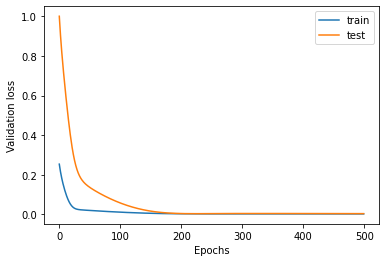

In [ ]:
# best test loss
model = Sequential()
model.add(LSTM(4, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(train_X, train_y, epochs=500, batch_size=5, validation_data=(test_X, test_y), verbose=2, shuffle=False)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()
plt.show()

In [ ]:
x = values[-10:][-10:]
x.shape

(10, 2)

In [ ]:
look_back = 10
def predict(num_prediction, model):
    prediction_list = values[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        print(x.shape)
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list
    
def predict_dates(num_prediction):
    state['date'] = dates
    last_date = state['date'].values[-1]

    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates

num_prediction = 30
forecast = predict(num_prediction, model)
forecast_dates = predict_dates(num_prediction)

In [ ]:
forecast

array([0.9999999, 2.112494 , 2.4851608, 2.6075842, 2.6597788, 2.6863606,
       2.7013676, 2.710437 , 2.7161834, 2.7199419, 2.7224867, 2.724416 ,
       2.7249546, 2.725138 , 2.7252233, 2.7252703, 2.7252975, 2.7253134,
       2.7253222, 2.7253275, 2.7253299, 2.7253313, 2.7253318, 2.725332 ,
       2.7253323, 2.7253323, 2.725332 , 2.7253323, 2.7253323, 2.7253323,
       2.7253323], dtype=float32)

In [ ]:
forecast_dates

[Timestamp('2021-05-21 00:00:00', freq='D'),
 Timestamp('2021-05-22 00:00:00', freq='D'),
 Timestamp('2021-05-23 00:00:00', freq='D'),
 Timestamp('2021-05-24 00:00:00', freq='D'),
 Timestamp('2021-05-25 00:00:00', freq='D'),
 Timestamp('2021-05-26 00:00:00', freq='D'),
 Timestamp('2021-05-27 00:00:00', freq='D'),
 Timestamp('2021-05-28 00:00:00', freq='D'),
 Timestamp('2021-05-29 00:00:00', freq='D'),
 Timestamp('2021-05-30 00:00:00', freq='D'),
 Timestamp('2021-05-31 00:00:00', freq='D'),
 Timestamp('2021-06-01 00:00:00', freq='D'),
 Timestamp('2021-06-02 00:00:00', freq='D'),
 Timestamp('2021-06-03 00:00:00', freq='D'),
 Timestamp('2021-06-04 00:00:00', freq='D'),
 Timestamp('2021-06-05 00:00:00', freq='D'),
 Timestamp('2021-06-06 00:00:00', freq='D'),
 Timestamp('2021-06-07 00:00:00', freq='D'),
 Timestamp('2021-06-08 00:00:00', freq='D'),
 Timestamp('2021-06-09 00:00:00', freq='D'),
 Timestamp('2021-06-10 00:00:00', freq='D'),
 Timestamp('2021-06-11 00:00:00', freq='D'),
 Timestamp